In [ ]:
! pip install transformers sentence-transformers datasets

In [ ]:
!pip install datasets

In [6]:

from datasets import load_dataset
data = load_dataset('emotion', split='train')
data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

AttributeError: ignored

In [12]:
data.set_format("pandas")
df = data[:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [16]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

In [23]:
def embedding_generator(df,model):
  tqdm.pandas()
  model = SentenceTransformer(model)
  df['Embeddings'] = df['text'].progress_apply(lambda x: model.encode(x))
  return df

In [24]:

def inputgen(df):
  a = []
  for i in tqdm(range(len(df))):
    a.append(np.array(df["Embeddings"][i]))
  a = np.array(a)
  print(a.shape)
  return a

In [25]:
df = df[0:2000]

model1 = "sentence-transformers/all-MiniLM-L6-v2"
inputgen_input = embedding_generator(df, model1)
print("Model 1 embedding completed")
embed_output = inputgen(inputgen_input)
print("Model 1 array completed")


100%|██████████| 2000/2000 [00:16<00:00, 124.29it/s]
<ipython-input-23-3b781e8df90a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Embeddings'] = df['text'].progress_apply(lambda x: model.encode(x))


Model 1 embedding completed


100%|██████████| 2000/2000 [00:00<00:00, 81492.64it/s]

(2000, 384)
Model 1 array completed


In [28]:
df_embd = pd.DataFrame(embed_output)
df = pd.concat([df, df_embd], axis=1)
df.head()

,text,label,Embeddings,0,1,2,3,4,5,6,...,374,375,376,377,378,379,380,381,382,383
0,i didnt feel humiliated,0,"[-0.055050936, -0.0076969657, 0.06353026, -0.0...",-0.055051,-0.007697,0.063530,-0.039664,0.116901,-0.123296,0.058080,...,0.063319,-0.044138,-0.034640,0.021249,-0.029084,0.084679,0.016152,0.015425,-0.135161,-0.064534
1,i can go from feeling so hopeless to so damned...,0,"[0.009238895, -0.052964322, 0.01926257, 0.0340...",0.009239,-0.052964,0.019263,0.034021,0.125202,0.027428,0.077058,...,-0.016320,-0.024402,-0.044897,0.132352,-0.082222,0.003469,0.095559,-0.060182,-0.027176,-0.026275
2,im grabbing a minute to post i feel greedy wrong,3,"[-0.07450293, -0.010641925, -0.0034595663, -0....",-0.074503,-0.010642,-0.003460,-0.073246,-0.018509,-0.026024,0.023559,...,0.050347,-0.030673,-0.001018,0.019752,0.078385,-0.010269,0.041514,-0.024779,-0.042020,0.024512
3,i am ever feeling nostalgic about the fireplac...,2,"[0.1085944, 0.095322214, 0.036476824, 0.015178...",0.108594,0.095322,0.036477,0.015178,0.089073,-0.012647,-0.089686,...,0.019334,-0.076964,-0.004122,0.023587,0.056529,0.024166,0.103731,-0.044091,-0.109329,0.034851
4,i am feeling grouchy,3,"[-0.016712187, -0.07877086, 0.032170083, -0.05...",-0.016712,-0.078771,0.032170,-0.053829,0.115593,-0.051190,0.132093,...,-0.011990,0.003192,-0.077645,-0.016146,0.007182,0.029738,0.059137,-0.062703,-0.019559,-0.057704


**Dimensionality reduction**

In [29]:
! pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=1f0ecfc7b6c431a446065378cb5e072c550c4b23a838c47002b85c252dcb9bc8
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [30]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
import numpy as np

In [31]:
def dimensionality_reduction(embed_arr, label):
  X_scaled = MinMaxScaler().fit_transform(embed_arr)
  mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
  df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
  df_emb["label"] = label
  print(df_emb)
  return df_emb

In [32]:
dim_emb_out = dimensionality_reduction(embed_output, df["label"])
print("UMAP completed")

              X          Y  label
0     18.261992   7.739311      0
1     15.845962   9.619434      0
2     16.071991   8.025002      3
3     13.885290   9.470761      2
4     18.012684  10.776094      3
...         ...        ...    ...
1995  16.665987   9.920237      0
1996  13.989463  10.872511      1
1997  15.222464   8.640060      5
1998  14.000204   9.412254      5
1999  15.297454   7.070045      1

[2000 rows x 3 columns]
UMAP completed


In [34]:
dim_emb_out.head()

,X,Y,label
0,18.261992,7.739311,0
1,15.845962,9.619434,0
2,16.071991,8.025002,3
3,13.885290,9.470761,2
4,18.012684,10.776094,3


**Visualizing Embeddings**

In [35]:
import matplotlib.pyplot as plt

In [37]:
dim_emb_out['label'].unique()

array([0, 3, 2, 5, 4, 1])

              X          Y  label
0     18.261992   7.739311      0
1     15.845962   9.619434      0
5     16.804714  10.869602      0
10    17.202028   8.926038      0
13    16.484955  11.429232      0
...         ...        ...    ...
1983  14.868382   5.988076      0
1987  15.118171   7.742510      0
1989  16.606295   9.337180      0
1992  15.973404  10.224393      0
1995  16.665987   9.920237      0

[544 rows x 3 columns]
              X          Y  label
8     15.306739   8.649679      1
11    14.872456   8.624611      1
14    12.584080   8.164601      1
15    16.898979  10.241128      1
22    14.486231   6.922131      1
...         ...        ...    ...
1988  14.780312  10.923882      1
1991  12.994534   9.055189      1
1993  15.984960   7.358032      1
1996  13.989463  10.872511      1
1999  15.297454   7.070045      1

[702 rows x 3 columns]
              X          Y  label
3     13.885290   9.470761      2
9     15.694174   6.661229      2
47    15.649001   7.260044      2


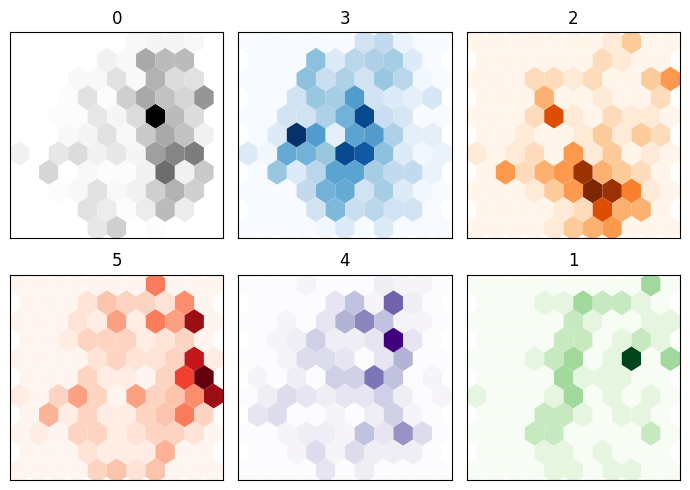

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels =df["label"].unique()
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = dim_emb_out.query(f"label == {i}")
    print(df_emb_sub)
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=10, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()